In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, func, inspect, desc

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
#Base.metadata.create_all(engine)

In [6]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [7]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [8]:
#save references to classes
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create a session
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


last_months = session.query(Measurement.date,Measurement.prcp).\
filter((Measurement.date < '2017-08-23') & (Measurement.date > '2016-08-23')).all()
last_months

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07'

In [17]:
#convert the result query into panda dataframe
new_df = pd.DataFrame(np.array(last_months), columns=(["date","Prcp"]))
new_df = new_df.set_index(['date'])
new_df


,Prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0
2016-08-27,0
2016-08-28,0.01
...,...
2017-08-18,None
2017-08-19,0.09
2017-08-20,None


In [18]:
# Sort the dataframe by date
new_df = new_df.sort_index()
new_df.head()


,Prcp
date,
2016-08-24,0.08
2016-08-24,None
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


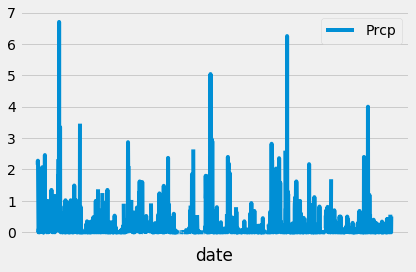

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
new_df.plot()
plt.xticks([])
plt.tight_layout()
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
new_df.describe()

,Prcp
count,2011.0
unique,160.0
top,0.0
freq,871.0


In [21]:
# Design a query to show how many stations are available in this dataset?
station_query = engine.execute('SELECT COUNT(station) FROM station').fetchall()
station_count = station_query[0][0]

print(f'There are {station_count} stations in the dataset.')

There are 9 stations in the dataset.


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = [Measurement.station, 
       func.count(Measurement.station)]
activest_query = session.query(*active_stations).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()
activest_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
USC281_query = engine.execute('SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM measurement WHERE station = "USC00519281"').fetchall()
USC281_stats = USC281_query[0]
USC281_stats

(54.0, 85.0, 71.66378066378067)

In [34]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC281_plotquery = engine.execute('SELECT date , tobs FROM measurement WHERE station = "USC00519281" AND date > "2016-08-23"').fetchall()
USC281_plotquery

usc281_df = pd.DataFrame(USC281_plotquery)
usc281_df = usc281_df.rename(columns={0: 'date', 1: 'tobs'})
usc281_df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


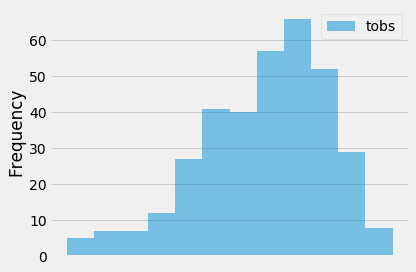

In [35]:
usc281_df.plot.hist(bins = 12, alpha=.5)
plt.xticks([])
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [32]:
# Plot the daily normals as an area plot with `stacked=False`
